## Get started

Create a Python environment using your favorite tool, then run the following cell to install `hybridlane` plus some plotting utilities. Note that because `hybridlane` is still marked as alpha, we need the `--pre` flag to install it. The `[all]` flag adds bosonic qiskit support.

Personally, I'm a big fan of the [uv](https://docs.astral.sh/uv/) package manager. If you're using that, you can create an ephemeral environment for this notebook with

```bash
$ uv tool run --isolated --with=pip jupyter lab hybridlane_demo.ipynb
```

In [1]:
# %pip install -q matplotlib
# %pip install -q --pre "hybridlane[all]"

In [2]:
import matplotlib.pyplot as plt

Below are the standard imports that we use for all Hybridlane circuits.

In [3]:
import numpy as np
import pennylane as qml
import hybridlane as hqml

## Demo 1: Fock ladder

The goals of this example are
- Give an introduction to defining circuits
- Show how to run them on Bosonic Qiskit
- Teach you how to create custom Hybrid gates that Hybridlane understands and can type check

---

### Executing a first circuit

We'll consider a simple quantum circuit that prepares the Fock state $\ket{n}$ on a qumode and then performs a Fock readout of $\hat{n}$ on the qumode. One way to create this state preparation circuit is through Jaynes-Cummings (JC) and Anti-Jaynes-Cummings (AJC) using an ancilla qubit. These gates are also known as Red and Blue sideband gates in the parlance of ion traps. In the convention of Hybridlane, the Red gate exchanges $\ket{0, n+1} \longleftrightarrow \ket{1, n}$

$$
\begin{align*}
JC(\theta, \varphi)\ket{1, n} &= \cos(\theta \sqrt{n+1})\ket{1,n} - ie^{i\varphi}\sin(\theta\sqrt{n+1})\ket{0, n+1}\\
JC(\theta, \varphi)\ket{0, n + 1} &= \cos(\theta \sqrt{n+1})\ket{0,n+1} - ie^{-i\varphi}\sin(\theta\sqrt{n+1})\ket{1, n}
\end{align*}
$$

Similarly, the Blue gate exchanges $\ket{0, n} \longleftrightarrow \ket{1, n+1}$

$$
\begin{align*}
AJC(\theta, \varphi)\ket{0, n} &= \cos(\theta \sqrt{n+1})\ket{0,n} - ie^{i\varphi}\sin(\theta\sqrt{n+1})\ket{1, n+1}\\
AJC(\theta, \varphi)\ket{1, n + 1} &= \cos(\theta \sqrt{n+1})\ket{1,n+1} - ie^{-i\varphi}\sin(\theta\sqrt{n+1})\ket{0, n}
\end{align*}
$$

Therefore, using an alternating sequence of Blue-Red-Blue-... gates, we can construct a Fock state starting from the initial computational state $\ket{0, 0}$. Each gate moves the state up by one quantum.

As a function, here's how we'd write that in Hybridlane. We compensate for the Rabi rate $\sqrt{n+1}$ so each gate performs a clean $\pi/2$ rotation, and we use $\varphi = \pi/2$ to remove the global phase that would accumulate.

In [4]:
def circuit(fock_state):
    for n in range(fock_state):
        rabi_rate = np.sqrt(n + 1)
        theta = np.pi / 2

        gate = hqml.Blue if n % 2 == 0 else hqml.Red
        gate(theta / rabi_rate, np.pi/2, wires=[0, 1])

The hybrid gates in Hybridlane all use the convention that qubits come before qumodes, so when Hybridlane analyzes this circuit, it will deduce that wire `0` is a qubit, and wire `1` is a qumode.

> 💡 It's not necessary to use numbers for wire labels - they can in fact be any "hashable" python object. So we could have called them `"q"` and `"m"` for instance.

This isn't quite ready to be a quantum circuit - we still need to perform the Fock measurement of the qumode, and we also have to bind the function to a device with the `@qml.qnode` decorator. First, let's construct the device representing the Bosonic Qiskit simulator, `bosonicqiskit.hybrid`.

In [5]:
dev = qml.device('bosonicqiskit.hybrid', max_fock_level=8)

Here we used a truncation of 8 Fock levels for all qumodes. Bosonic Qiskit will therefore use $\log_2 8 = 3$ qubits per qumode. Note that because Bosonic Qiskit uses qubits, we are restricted to powers of 2.

> 💡 The device also has support for per-qumode truncation for more granular control. [Here](https://github.com/pnnl/hybridlane/blob/3f1dace1d43cb3aa51bc4f729220bc4bc2b23d03/test/devices/bosonic_qiskit/test_device.py#L178) is an example showing how to use different truncations per qumode.

Simply wrapping our `circuit` function with the decorator `@qml.qnode(dev)` will make it an executable circuit on the Bosonic Qiskit device. As for the measurement, the expectation value is computed through `hqml.expval(observable)`, and we choose the number operator on the qumode, `hqml.N(1)`.

> ❗ For existing Pennylane users, use the Hybridlane `hqml.expval` function, not the Pennylane `qml.expval` one. This helps keep the type checker happy.

Here's the complete circuit definition.

In [6]:
# Bind the function to the device
@qml.qnode(dev)
def circuit(fock_state):
    # The state preparation that we had before
    for n in range(fock_state):
        rabi_rate = np.sqrt(n + 1)
        theta = np.pi / 2

        gate = hqml.Blue if n % 2 == 0 else hqml.Red
        gate(theta / rabi_rate, np.pi/2, wires=[0, 1])
    
    # Measure Fock number of the qumode
    return hqml.expval(hqml.N(1))

`circuit` is now an executable quantum circuit. You can call it like this:

In [7]:
fock_state = 5
mean_photon_number = circuit(fock_state)
mean_photon_number

array(5.)

Hybridlane also has utilities to draw hybrid circuits by extending Pennylane's drawing capabilities. Using the `hqml.draw_mpl` function, you can instead draw the circuit and Hybridlane will annotate the diagram with qubit and qumode labels, and it has special drawing features for some hybrid gates. This provides a way to visualize what wire types Hybridlane inferred for your circuit.

Note that the result of `hqml.draw_mpl(circuit)` is itself another function that accepts your circuit parameters.

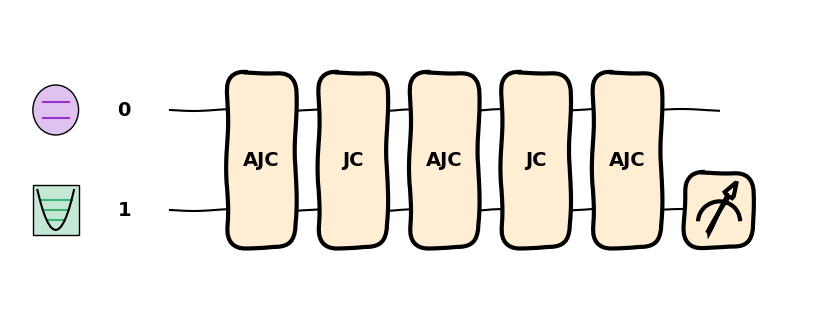

In [8]:
hqml.draw_mpl(circuit, style="sketch")(fock_state)
plt.show()

**Exercise**: Try replacing the measurement `hqml.expval` with `hqml.var` and see what you get. You can also measure the spin state of the qubit above with the observable `qml.Z(0)`, but keep in mind that Hybridlane uses the convention that $\ket{g} = \ket{0}$ is the $+1$ eigenstate of the Pauli $Z$ operator.

### Defining a reusable gate

Preparing a definite Fock state is a primitive that we'll want in future circuits. Let's convert our state preparation circuit above into a gate. Gates in Pennylane/Hybridlane are Python classes that inherit from `Operation` and contain a number of important attributes, such as:

- `num_wires`: The total number of wires (qubit + qumode) the gate acts on
- `num_params`: The number of "trainable" inputs to the gate
- `grad_method`: The best algorithm to compute the gradient w.r.t. gate parameters (we're not going to worry about that)

In addition to these attributes, Hybridlane needs to determine which wires are qubits and qumodes. This is largely determined through the class(es) that the gate inherits from. On top of `Operation`, gates can also be a `CVOperation` or `Hybrid`.

These are important because Hybridlane's inference algorithm works something like this:

```python
if op is Hybrid:
    qubits, qumodes = op.split_wires()
elif op is CVOperation:
    qumodes = op.wires
else:
    qubits = op.wires
```

So when designing gates, use the appropriate superclass so that hybridlane can infer the wire types. Because our circuit was hybrid qubit-qumode (we had one ancilla qubit and one qumode), we'll inherit from `Hybrid`.

Furthermore, our gate is a composite gate made up of more primitive operations. Therefore, we override the `compute_decomposition` method to tell Pennylane the definition of our gate. Here's the attributes of our gate:

- `num_wires = 2`: One qubit and one qumode
- `num_params = 1`: One parameter for the target Fock state $\ket{n}$
- `num_qumodes = 1`: A single qumode. This is an attribute specific to the `Hybrid` mixin.

This is the complete gate definition:

In [9]:
from pennylane.ops import Operation
from hybridlane.ops.mixins import Hybrid

# Inherit from both Operation and Hybrid
class FockLadder(Operation, Hybrid):
    num_wires = 2
    num_params = 1
    num_qumodes = 1

    # Constructor takes the target fock state and will become accessible as parameters[0]
    def __init__(self, n, wires=None, id=None):
        super().__init__(n, wires=wires, id=id)

    # Give the definition in terms of red/blue gates, just like in our circuit above.
    # While in the circuit we could just call the gate names and they were automatically queued,
    # here we have to add them to a list and return that list ourselves.
    @staticmethod
    def compute_decomposition(*params, wires, **hyperparameters) -> list[Operation]:
        n = params[0]
        decomposition = []

        for n in range(fock_state):
            rabi_rate = np.sqrt(n + 1)
            theta = np.pi / 2
    
            gate = hqml.Blue if n % 2 == 0 else hqml.Red
            decomposition.append(gate(theta / rabi_rate, np.pi/2, wires=[0, 1]))

        return decomposition

Now we can repeat our example above and use our custom gate.

In [10]:
@qml.qnode(dev)
def circuit_with_fockladder(n):
    FockLadder(n, wires=[0, 1])
    return hqml.expval(hqml.N(1))

This gate will now be drawn as its own entity in the circuit diagrams. And because we inherited from `Hybrid`, Hybridlane was able to infer which wires were qubits and which were qumodes. Note that inheriting from `Hybrid` automatically enforces the convention that qubits come before qumodes.

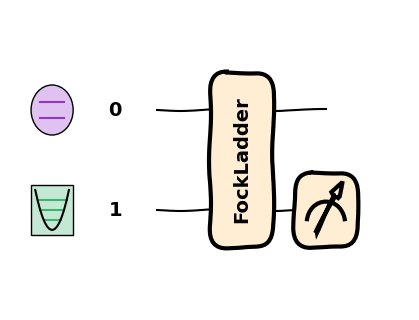

In [11]:
hqml.draw_mpl(circuit_with_fockladder, style="sketch")(fock_state)
plt.show()

We can also execute the circuit and see that we get the same result. Our custom gate is not known to Bosonic Qiskit, but because we gave the decomposition, the simulator uses that decomposition and can run it anyways.

In [12]:
circuit_with_fockladder(fock_state)

array(5.)

This gate `FockLadder` is a template provided for you in Hybridlane.

## Demo 2: Quantum phase estimation

This second demo shows more functionality of Hybridlane:
- Using existing Pennylane qubit algorithms
- Implementing more advanced decompositions
- Exporting circuits to OpenQASM 3

For a nice review of quantum phase estimation (QPE), see the [Pennylane blog post](https://pennylane.ai/qml/demos/tutorial_qpe). Additionally, this example was inspired from the Bosonic Qiskit tutorial on [simulating the dispersive JC hamiltonian](https://github.com/C2QA/bosonic-qiskit/blob/c02e0f16f33bfd6f1784725cf50158d1a21c192a/tutorials/jaynes-cummings-model/jaynes-cummings-dispersive.ipynb).

---

This demo uses the experimental graph decomposition of Pennylane, which needs to be enabled with

In [13]:
qml.decomposition.enable_graph()


Consider the dispersive Jaynes-Cummings Hamiltonian representing our system of interest

$$H = \omega_r \hat{n} - \omega_q/2 Z - \chi/2 Z\hat{n}$$

> ⚠️ Here we use the minus sign in front of $Z$ operators because in Hybridlane, $\ket{0} = \ket{g}$ is the +1 eigenstate of $Z$ to match the typical quantum information convention. This means that $-\frac{1}{2}Z$ is the energy operator of a spin state instead of $\frac{1}{2}Z$.

Imagine that we would like to measure the energy of an unknown eigenstate $\ket{\psi}$. We can do this by applying QPE to the unitary $U(t) = e^{-iHt}$, provided we have the ability to synthesize the qubit-controlled variant $cU(t) := \ket{0}\bra{0}I + \ket{1}\bra{1}U(t)$. This would result in measuring the phase $\phi$ such that

$$e^{-iEt} = e^{2\pi i \phi}$$

which can then be related back to the energy as $E = \frac{-2\pi\phi}{t}$. We'll assume $t=1$ for simplicity in the code.

### Defining the unitary $U(t)$

First, we need to define our gate $U(t) = e^{-iHt}$. The terms of $H$ commute (as conveniently chosen), so

$$
\begin{align*}
U(t) &= e^{-i\omega_r t \hat{n}}e^{i\frac{\omega_q t}{2} Z}e^{i \frac{\chi t}{2} Z\hat{n}} \\
     &= R(\omega_r t)R_z(-\omega_q t)CR(-\chi t)
\end{align*}
$$

using the gates defined in Pennylane and Hybridlane. Additionally, because QPE uses powers of $U^z$, we need to also teach Pennylane how to decompose this. $U(t)$ is an "arbitrary angle" gate and has the relation $U^z(t) = U(zt)$. Below we give the code for our gate.

In [14]:
class JCEvolution(Operation, Hybrid):
    num_params = 4
    num_wires = 2
    num_qumodes = 1

    resource_keys = set()

    def __init__(self, t, omega_r = 1, omega_q = -1, chi = 0.1, wires=None, id=None):
        super().__init__(t, omega_r, omega_q, chi, wires=wires, id=id)

    def label(self, decimals: int | None = None, base_label: str | None = None, cache: dict | None = None) -> str:
        return super().label(decimals, base_label or "U", cache)

    @property
    def resource_params(self):
        return {}

# The decomposition in terms of R, Rz, and CR
@qml.register_resources({hqml.Rotation: 1, hqml.ConditionalRotation: 1, qml.RZ: 1})
def _jc_decomp(t, omega_r, omega_q, chi, wires, **_):
    hqml.Rotation(t*omega_r, wires[1])
    qml.RZ(-t*omega_q, wires[0])
    hqml.ConditionalRotation(-t*chi, wires)

# The decomposition U†(t) = U(-t)
@qml.register_resources({JCEvolution: 1})
def _jc_adjoint(t, *params, wires, **_):
    JCEvolution(-t, *params, wires=wires)

# The decomposition U^z(t) = U(zt)
@qml.register_resources({JCEvolution: 1})
def _jc_pow(t, *params, wires, z, **_):
    JCEvolution(z * t, *params, wires=wires)

qml.add_decomps(JCEvolution, _jc_decomp)
qml.add_decomps("Adjoint(JCEvolution)", _jc_adjoint)
qml.add_decomps("Pow(JCEvolution)", _jc_pow)

We can visualize our decomposition by using the `qml.transforms.decompose` transformation. We pass in the Bosonic Qiskit native gates as our decomposition target.

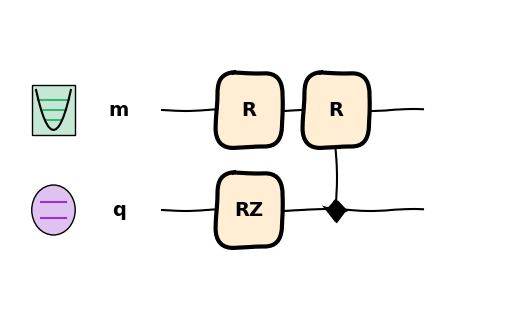

In [15]:
from functools import partial
from hybridlane.devices.bosonic_qiskit.gates import supported_operations as native_gates

dev = qml.device('bosonicqiskit.hybrid', max_fock_level=8)

@partial(qml.transforms.decompose, gate_set=native_gates)
@qml.qnode(dev)
def jc_diagram(t):
    JCEvolution(t, wires=["q", "m"])

hqml.draw_mpl(jc_diagram, style="sketch")(1)
plt.show()

### Defining the controlled gate $cU(t)$

Recall that for QPE, we need to synthesize the controlled version of $U(t)$, $cU(t) = \ket{0}\bra{0}I + \ket{1}\bra{1}U(t)$. Pennylane already knows to write this in terms of the controlled variants of the gates in our decomposition of $U(t)$: $cR$, $cR_z$, and $cCR$. There is already a built-in gate for $cR_z$, but we need to show Pennylane how to synthesize the other qubit-controlled gates.

To do this, it'll be useful to keep in mind that for a unitary $U = e^{-itG}$ for some (hermitian) generator $G$, its "conditional" version $CU$ (with a capital C) is

$$
\begin{align*}
CU := e^{-it Z\otimes G} &= \ket{0}\bra{0}U + \ket{1}\bra{1}U^\dagger \\
                         &= (c_0U)(c_1U^\dagger)
\end{align*}
$$

<div style="display: flex; justify-content: center;">
<img src="cond_to_ctrl.png" width="600px"/>
</div>

Reversing this, we see that if we have access to $U$ and its conditioned version $CU$, we can synthesize the qubit-controlled version $cU$ as

$$
\begin{align*}
cU &= \sqrt{U} \sqrt{CU}^\dagger \\
   &= \sqrt{U} (\ket{0}\bra{0} \sqrt{U}^\dagger + \ket{1}\bra{1} \sqrt{U}) \\
   &= \ket{0}\bra{0} \sqrt{UU^\dagger} + \ket{1}\bra{1} \sqrt{U^2} \\
   &= \ket{0}\bra{0} I + \ket{1}\bra{1} U
\end{align*}
$$

We can apply this to synthesize the controlled-rotation gate $cR(\theta)$ because we know its conditioned version $CR(\theta)$.

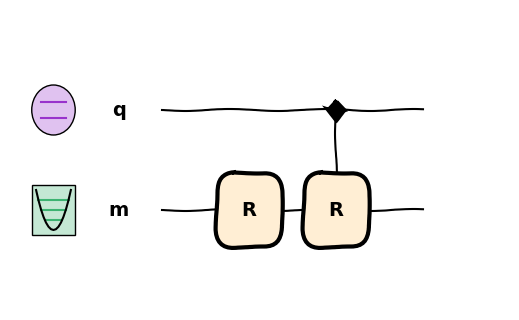

In [16]:
def _one_ctrl_wire(num_control_wires, **kwargs):
    return num_control_wires == 1

# Decomposition for the cR gate
@qml.register_condition(_one_ctrl_wire)
@qml.register_resources({hqml.ConditionalRotation: 1, hqml.Rotation: 1})
def _controlled_rotation_decomp(theta, wires, **_):
    hqml.Rotation(theta/2, wires[1])
    qml.adjoint(hqml.ConditionalRotation)(theta, wires) # note: CR uses θ/2 convention


qml.add_decomps("C(Rotation)", _controlled_rotation_decomp)

@partial(qml.transforms.decompose, gate_set=native_gates)
@qml.qnode(dev)
def controlled_rotation(t):
    qml.ctrl(hqml.Rotation(t, ["m"]), control=["q"])

hqml.draw_mpl(controlled_rotation, style="sketch", wire_order=["q", "m"])(1)
plt.show()

Creating the equivalent identity for the $cCR$ gate is more complicated - essentially, we need access to a "double" conditioned-rotation gate $C_2R(\theta) = e^{-i \theta/2 ZZ\hat{n}}$. This behaves just like the conditional rotation gate, except now it's conditioned on the _parity_ of two qubits instead of one (which is why I think we should start calling these "parity-conditioned" gates).

One can construct this gate using CNOT gates, as

$$C_2R(\theta) = CNOT_{c,q}~CR_{q,m}(\theta)~CNOT_{c,q}$$

(and in general, this can be extended to create a gate conditioned on the parity of an arbitrary number of qubits).

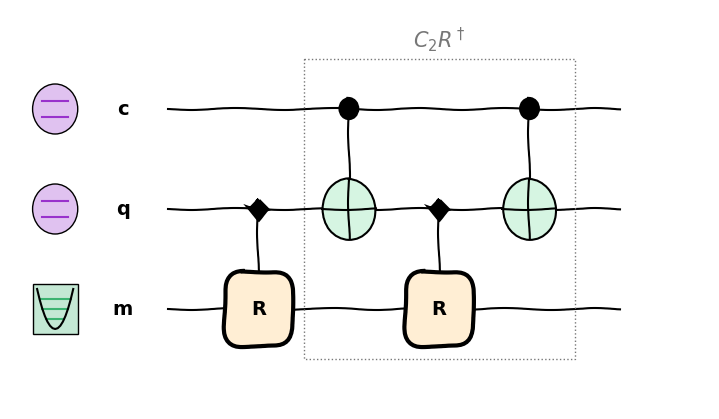

In [17]:
# Decomposition for the cCR gate
@qml.register_condition(_one_ctrl_wire)
@qml.register_resources({hqml.ConditionalRotation: 2, qml.CNOT: 2})
def _controlled_cr_decomp(theta, wires, **_):
    # Sqrt(CR)
    hqml.ConditionalRotation(theta/2, wires[1:])

    # Sqrt(C2R)
    qml.CNOT(wires[:2])
    qml.adjoint(hqml.ConditionalRotation)(theta/2, wires[1:])
    qml.CNOT(wires[:2])

qml.add_decomps("C(ConditionalRotation)", _controlled_cr_decomp)

@partial(qml.transforms.decompose, gate_set=native_gates)
@qml.qnode(dev)
def controlled_cr(t):
    qml.ctrl(hqml.ConditionalRotation(t, ["q", "m"]), control=["c"])

fig, ax = hqml.draw_mpl(controlled_cr, style="sketch", wire_order=["c", "q", "m"])(1)
box = plt.Rectangle((0.5, -0.5), 3, 3, linestyle="dotted", facecolor="#ffffff00", edgecolor="#777777")
ax.add_patch(box)
ax.annotate(r"$C_2R^\dagger$", (2.0, -0.7), ha='center', va='center', color="#777777", fontsize=15)
plt.show()

Armed with these decompositions, we can now implement the actual QPE circuit for our Hamiltonian. We'll use the high-level [QuantumPhaseEstimation](https://docs.pennylane.ai/en/stable/code/api/pennylane.QuantumPhaseEstimation.html) template provided by Pennylane to reduce work and show that Hybridlane integrates with your favorite algorithms.

In [18]:
from pennylane.templates import QuantumPhaseEstimation
from pennylane.wires import Wires
from hybridlane.devices.bosonic_qiskit.gates import supported_operations as native_gates
from hybridlane.sa import ComputationalBasis, BasisSchema

dev = qml.device('bosonicqiskit.hybrid', max_fock_level=8)

# Define the Hamiltonian parameters
t = 1
omega_r = 2
omega_q = 5
chi = 0.1

# Construct the unitary U(t) outside of the circuit so it's not queued into the circuit operations
target_wires = ("qubit", "mode")
U = JCEvolution(t, omega_r=omega_r, omega_q=omega_q, chi=chi, wires=target_wires)


@partial(qml.transforms.decompose, gate_set=native_gates)
@qml.set_shots(15)
@qml.qnode(dev)
def circuit_qpe(n_bits):
    # State prep: We'll prepare the eigenstate |g, 4> = |0, 4>.
    hqml.FockLadder(4, ["qubit", "mode"])

    # Use Pennylane QPE template
    estimation_wires = range(n_bits)
    QuantumPhaseEstimation(U, estimation_wires=estimation_wires)

    # Define the computational basis measurement over the estimation qubits.
    # In general, Discrete can mean Z basis (qubits) or Fock basis (qumodes), but Hybridlane understands it's
    # Z-basis because estimation_wires are all qubits.
    schema = BasisSchema(
        {Wires(w): ComputationalBasis.Discrete for w in estimation_wires}
    )
    return hqml.sample(schema=schema)

The circuit we defined is quite short (this feels almost like cheating to say this after the work we did above).

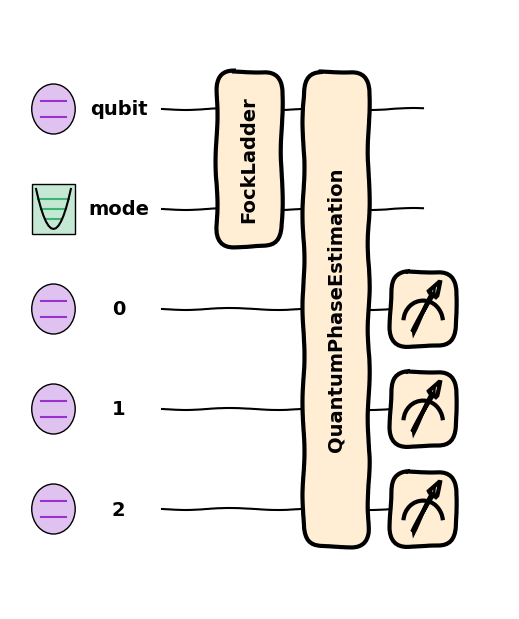

In [19]:
hqml.draw_mpl(circuit_qpe, level="top", style="sketch")(3)
plt.show()

Changing the decomposition to the `device` level shows the full circuit that will get executed on the simulator. Notice how it uses the rules we gave it. The overall circuit depth is only one $cU$ gate per estimation qubit because $U(t)$ is an arbitrary-angle gate. This would be much deeper if our unitary was made of discrete gates (e.g. $Z$, $T$).

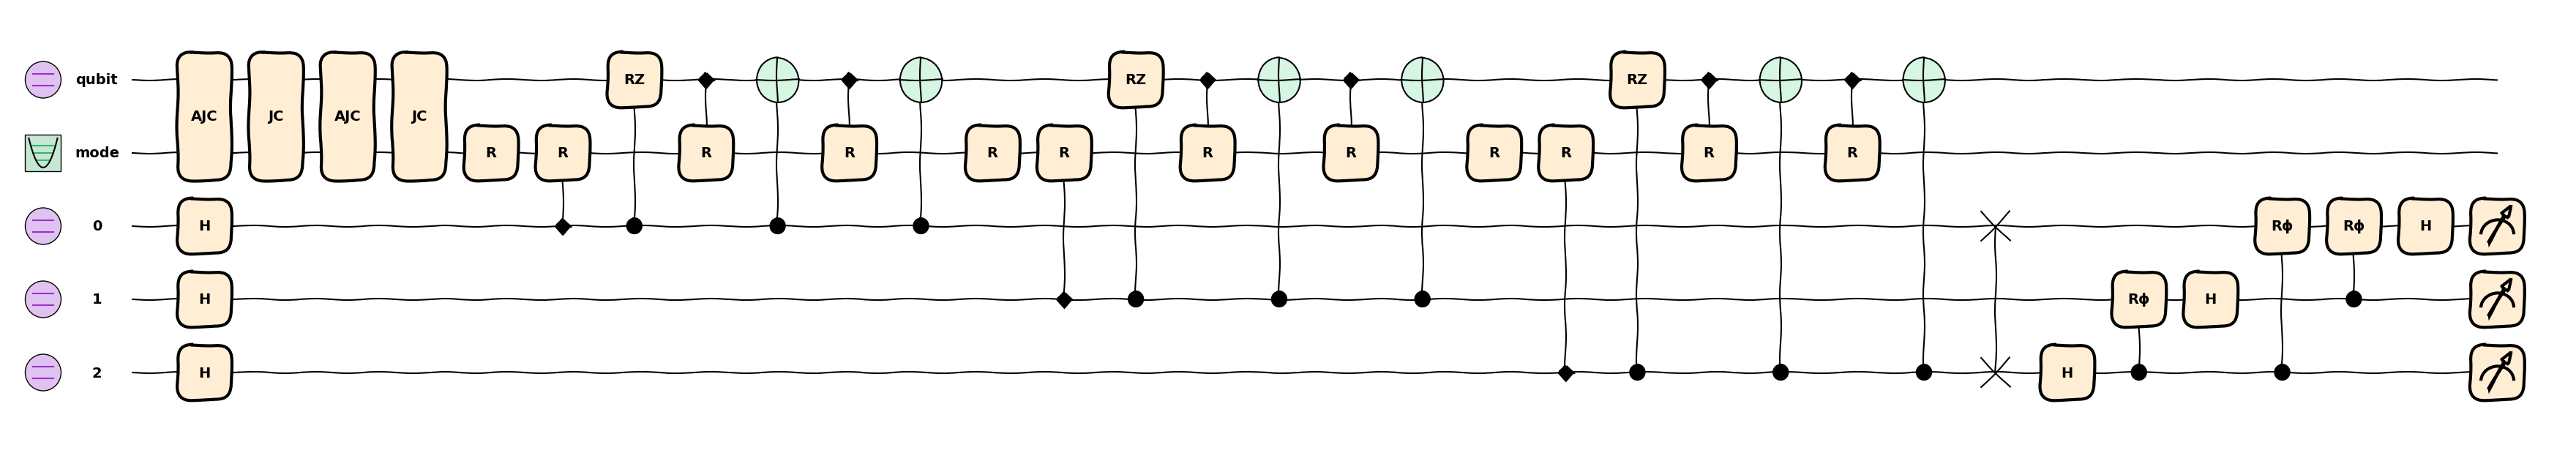

In [20]:
hqml.draw_mpl(circuit_qpe, level="device", style="sketch")(3)
plt.show()

Here we use a small number of shots to show what the output looks like. Different from what you might be used to in Pennylane, Hybridlane returns a dictionary that maps the wire labels to the measured basis states. From the QPE template, wire `0` is the MSB.

In [21]:
bitstrings = circuit_qpe(10)
bitstrings.basis_states

{0: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 1: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 2: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8),
 3: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 4: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=uint8),
 5: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8),
 6: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8),
 7: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8),
 8: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 9: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=uint8)}

To generate a histogram, one can use a larger number of shots with the `qml.set_shots` transform. We define a utility function to convert the basis states into the phase angles $\phi$.

> ❗ We use $1 - \phi$ because phase output by our circuit is in the range $(-1, 0]$ from our definition that $U = e^{-iHt}$. If we used a positive $e^{iHt}$, then this wouldn't require conversion.

Mode: ModeResult(mode=np.float64(5.301437602932776), count=np.int64(854))


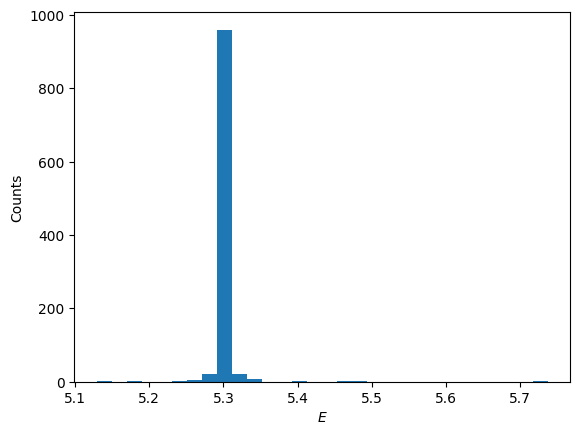

In [22]:
from scipy.stats import mode

def bitstring_to_phase(result):
    arrs = [2 ** (-w - 1) * bits for w, bits in result.basis_states.items()]
    return sum(arrs)

bitstrings = qml.set_shots(circuit_qpe, shots=1024)(10)
phase_estimated = bitstring_to_phase(bitstrings)
energies = 2 * np.pi * (1 - phase_estimated) / t

print(f"Mode: {mode(energies)}")
plt.hist(energies, bins=30)
plt.xlabel("$E$")
plt.ylabel("Counts")
plt.show()

We obtain a large concentration around $E = 5.3$, suggesting we did prepare an eigenstate.

**Exercise**: Vary the hamiltonian parameters and state preparation circuit. Do you get the energy you expect? (If not, file an issue on Github! 🐛)

### Exporting to OpenQASM

Hybridlane provides a utility function `to_openqasm` that exports circuits to a variant of OpenQASM 3 with some hybrid CV-DV modifications. Here's what our circuit looks like, using a small number of estimation qubits to keep the output short.

In [23]:
qasm = hqml.to_openqasm(circuit_qpe, precision=5, level="device")(3)
print(qasm)


OPENQASM 3.0;
include "stdgates.inc";

const int homodyne_precision_bits = 32;
const int fock_readout_precision_bits = 32;
include "cvstdgates.inc";


qubit[4] q;
qumode[1] m;

def state_prep() {
    reset q;
    reset m;
    cv_ajc(1.57080, 1.57080) q[0], m[0];
    cv_jc(1.11072, 1.57080) q[0], m[0];
    cv_ajc(0.90690, 1.57080) q[0], m[0];
    cv_jc(0.78540, 1.57080) q[0], m[0];
    h q[1];
    h q[2];
    h q[3];
    cv_r(4.00000) m[0];
    cv_cr(-8.00000) q[1], m[0];
    crz(-20.00000) q[1], q[0];
    cv_cr(-0.20000) q[0], m[0];
    cx q[1], q[0];
    cv_cr(0.20000) q[0], m[0];
    cx q[1], q[0];
    cv_r(2.00000) m[0];
    cv_cr(-4.00000) q[2], m[0];
    crz(-10.00000) q[2], q[0];
    cv_cr(-0.10000) q[0], m[0];
    cx q[2], q[0];
    cv_cr(0.10000) q[0], m[0];
    cx q[2], q[0];
    cv_r(1.00000) m[0];
    cv_cr(-2.00000) q[3], m[0];
    crz(-5.00000) q[3], q[0];
    cv_cr(-0.05000) q[0], m[0];
    cx q[3], q[0];
    cv_cr(0.05000) q[0], m[0];
    cx q[3], q[0];
    swap q[1], q

Notice that we have a `qumode` keyword to declare qumode registers and a standard library `cvstdgates.inc` of hybrid gates. You can find the standard library under `examples/cvstdgates.inc`. While not shown in this example, Hybridlane will also try to insert homodyne or Fock measurements into the IR for measured qumodes.

**Exercise**: Try using the `strict=True` flag in the `to_openqasm` function and note what changes happen to the intermediate representation.

## Demo 3: Programming the ion trap

This final demo aims to show some features regarding the Sandia Qscout ion trap:
- Introduce the `sandiaqscout.hybrid` device and how to program at the native gate level
- Give a simple calibration example and show a full workflow from simulation to transpiling and exporting to Jaqal

> ⚠️ This module is very experimental and we still need to work with the Qscout team to ensure it accurately reflects the device capabilities. However, we hope it shows the utility of Hybridlane to define custom backends and how to integrate various projects together.

The calibration example is based on Bosonic Qiskit's tutorial on [simulating displacement calibration](https://github.com/C2QA/bosonic-qiskit/blob/c02e0f16f33bfd6f1784725cf50158d1a21c192a/tutorials/displacement-calibration/displacement-calibration.ipynb).

---

In this demo, we'll be programming hybrid circuits for the Sandia Qscout ion trap and replicating a common workflow used in qubit software:

defining the circuit → simulating → transpiling to hardware → executing

We won't be able to actually execute the circuit because there's no cloud access to the device, but we'll export the circuit to the [Jaqal](https://arxiv.org/abs/2008.08042) format used by the ion trap. Like before, this example uses the experimental graph decomposition module of Pennylane.

In [24]:
qml.decomposition.enable_graph()

Additionally, we provide this plotting style to draw circuits on the ion trap.

In [25]:
from hybridlane.devices.sandia_qscout import get_default_style

draw_options = get_default_style()

### Hardware-level programming

Hybridlane contains all of the relevant Qscout code under the `hybridlane.devices.sandia_qscout` package, containing
- `QscoutIonTrap`: A dummy backend that serves as a circuit compilation target and validates that gates obey the hardware constraints
- `ops`: An implementation of the native qumode gates. (You can use the standard Pennylane qubit gates too)
- `to_jaqal`: A transformation similar to `to_openqasm` that outputs a circuit to the Jaqal format.

The currently available native qubit-qumode gates are:
- **Red** (`Red`): The red sideband gate
- **Blue** (`Blue`): The blue sideband gate
- **SidebandProbe** (`Rt_SBProbe`): A general sideband operation
- **ConditionalXDisplacement** (`SDF`): A conditional displacement with an $X$ generator instead of a $Z$ generator
- **ConditionalXSqueezing** (`RampUp`): A conditional squeezing similarly based on $X$ instead of $Z$
- **FockStatePrep** (`FockState`): A sometimes-native gate that prepares a Fock state
- **NativeBeamsplitter** (`Beamsplitter`): The beamsplitter operation the device, renamed to avoid conflict with the Hybridlane `Beamsplitter` gate since the parameters differ

Each corresponds to the Jaqal instruction given in the parentheses. You can get the full list of native gates with

In [26]:
from hybridlane.devices.sandia_qscout.device import NATIVE_GATES

NATIVE_GATES

{'Adjoint(S)',
 'Adjoint(SX)',
 'AntiJaynesCummings',
 'ConditionalXDisplacement',
 'ConditionalXSqueezing',
 'FockStatePrep',
 'GlobalPhase',
 'IsingXX',
 'IsingYY',
 'IsingZZ',
 'JaynesCummings',
 'NativeBeamsplitter',
 'PauliX',
 'PauliY',
 'PauliZ',
 'R',
 'RX',
 'RY',
 'RZ',
 'S',
 'SX',
 'SidebandProbe'}


Many of these gates have constraints (e.g. only working on the "tilt" modes), so the way to guarantee you define an executable circuit is to use the hardware wires. The qubits can be addressed through integers $i \in 0,\dots,n-1$, while the hardware qumodes use strings with the format `"a<axis>m<mode>"`, where $axis \in \{0, 1\}$ and $mode \in 0, ..., n-1$, giving $2n$ qumodes. However, the center-of-mass (COM) qumodes ($mode = 0$) are often undesirable, and so by default, the `sandiaqscout.hybrid` device only lets you use modes 1...n-1. You can use the COM qumodes if you pass the flag `use_com_modes=True` to the device.

Here's a simple example of performing a conditional displacement on a tilt mode ($mode = 1$).

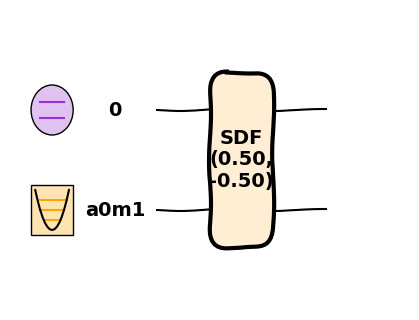

In [27]:
from hybridlane.devices.sandia_qscout import ops

dev = qml.device('sandiaqscout.hybrid', use_hardware_wires=True)

@qml.set_shots(10)
@qml.qnode(dev)
def circuit(beta):
    ops.ConditionalXDisplacement(np.real(beta), np.imag(beta), [0, "a0m1"])

hqml.draw_mpl(circuit, style="sketch", decimals=2, **draw_options)(0.5 - 0.5j)
plt.show()

Here's another example using the Blue gate that can access higher modes.

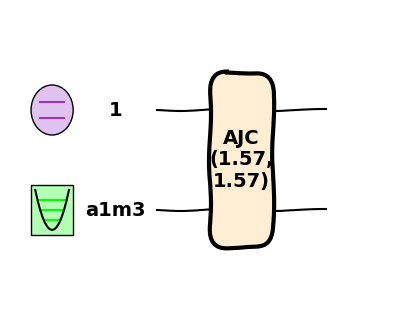

In [28]:
@qml.qnode(dev)
def circuit():
    ops.Blue(np.pi/2, np.pi/2, [1, "a1m3"])

hqml.draw_mpl(circuit, style="sketch", decimals=2, **draw_options)()
plt.show()

### Virtual wires

By using the default `use_hardware_wires=False` flag, the device can also perform virtual wire assignment to satisfy the constraints of the device, if possible. We'll also show some of the decompositions built-in to the device.

Consider the following circuit:

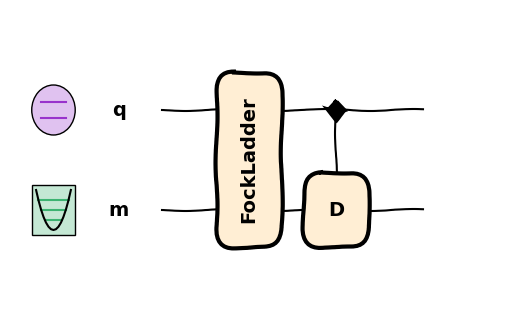

In [29]:
dev = qml.device('sandiaqscout.hybrid', n_qubits=6)

@qml.set_shots(10)
@qml.qnode(dev)
def circuit():
    hqml.FockLadder(3, ["q", "m"])
    hqml.ConditionalDisplacement(0.5, 0, ["q", "m"])

hqml.draw_mpl(circuit, style="sketch", **draw_options)()
plt.show()

The `FockLadder` instruction can be applied to any qumode - if it's on the tilt modes, it'll use the native `FockStatePrep` gate. But otherwise it'll just be decomposed into the Blue-Red ladders we've seen before, and those are supported on all qumodes. The `ConditionalDisplacement` gate is not native; it becomes a native `ConditionalXDisplacement` plus some Hadamard gates. Because the `ConditionalXDisplacement` is defined only on a certain qumode and both gates act on the same qumode, they will be assigned to match the constraints on the `ConditionalXDisplacement` gate. The Hadamard gates are also not native and get decomposed into rotation gates.

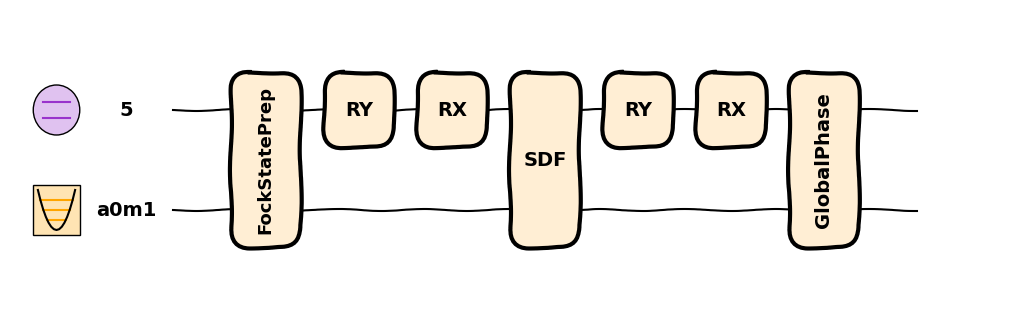

In [30]:
hqml.draw_mpl(circuit, style="sketch", level="device", **draw_options)()
plt.show()

### The full pipeline

Now we'll consider an example circuit composed of gates that can be simulated in Bosonic Qiskit and also decomposed to the native ion trap gates (that is a rather limited set, to be fair).

We'll use this example of calibrating a conditional displacement gate. Note that while the original example uses some displacement gates, we can synthesize them on the ion trap using conditional displacement gates - as long as we start use a clean (reset) ancilla qubit. Therefore, the circuit on the qumode and qubit is effectively

$$
\begin{align*}
U(r) &= H~D(-ir)~CD(-r)~D(ir)~CD(r)~H \\
     &= R_x(-4r^2)
\end{align*}
$$

following the analysis in [arXiv:2407.10381](https://arxiv.org/abs/2407.10381) (see p. 68-69). This results in a final $Z$ measurement of $\langle Z\rangle = \cos(4r^2)$.

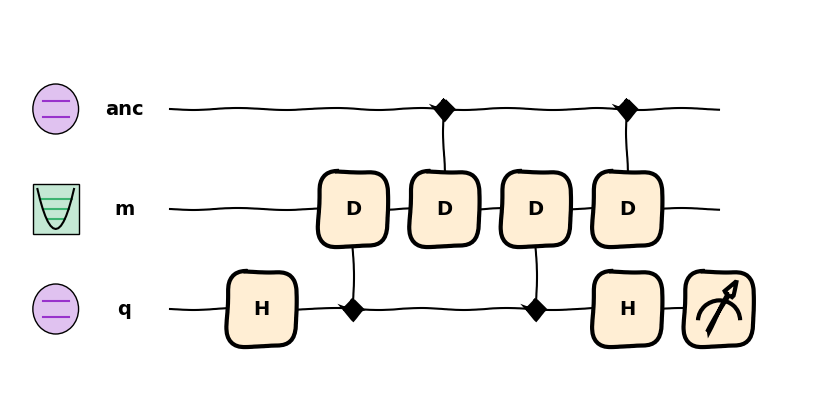

In [31]:
def circuit(dist):
    qml.H('q')
    hqml.ConditionalDisplacement(dist, 0, ['q', 'm'])
    hqml.ConditionalDisplacement(dist, np.pi/2, ['anc', 'm'])
    hqml.ConditionalDisplacement(-dist, 0, ['q', 'm'])
    hqml.ConditionalDisplacement(-dist, np.pi/2, ['anc', 'm'])
    qml.H('q')
    return hqml.expval(qml.Z('q'))

hqml.draw_mpl(circuit, style="sketch")(0.5)
plt.show()

Let's simulate it on Bosonic Qiskit analytically.

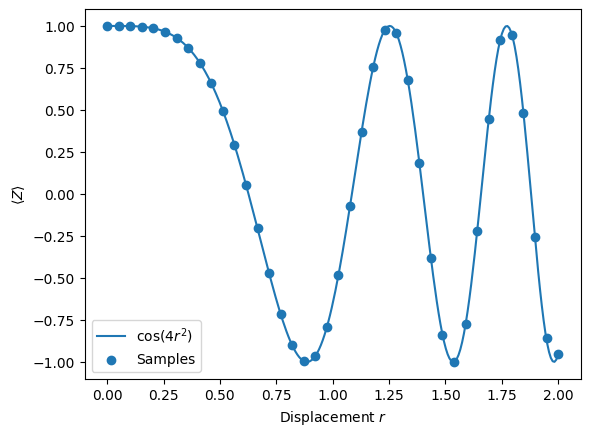

In [32]:
dev = qml.device('bosonicqiskit.hybrid', max_fock_level=16)
qnode = qml.QNode(circuit, dev)

r_sample = np.linspace(0, 2, 40)
expval = list(map(qnode, r_sample))

r_exact = np.linspace(0, 2, 250)
plt.plot(r_exact, np.cos(4 * r_exact**2), label=r'$\cos(4r^2)$')

plt.scatter(r_sample, expval, label="Samples")
plt.xlabel("Displacement $r$")
plt.ylabel(r"$\langle Z\rangle$")
plt.legend()
plt.show()

Our simulated circuits match the theoretical expectation, so now we're confident the circuit definition is correct. We'd like to export it to run on the hardware. This can be done by wrapping the circuit in the Sandia ion trap device instead. Because this is a benchmarking task, we'll also turn off optimization.

In [33]:
dev = qml.device('sandiaqscout.hybrid', optimize=False, n_qubits=2)
qnode = qml.set_shots(qml.QNode(circuit, dev), 1024)

Just like before, we can visualize the circuit and see what layout the device chose. The device chose the mapping

```
q -> 1
m -> a0m1
anc -> 0
```

to satisfy the constraint on the SDF gate. Note that none of the `GlobalPhase` gates will be included in the IR, so don't worry about them.

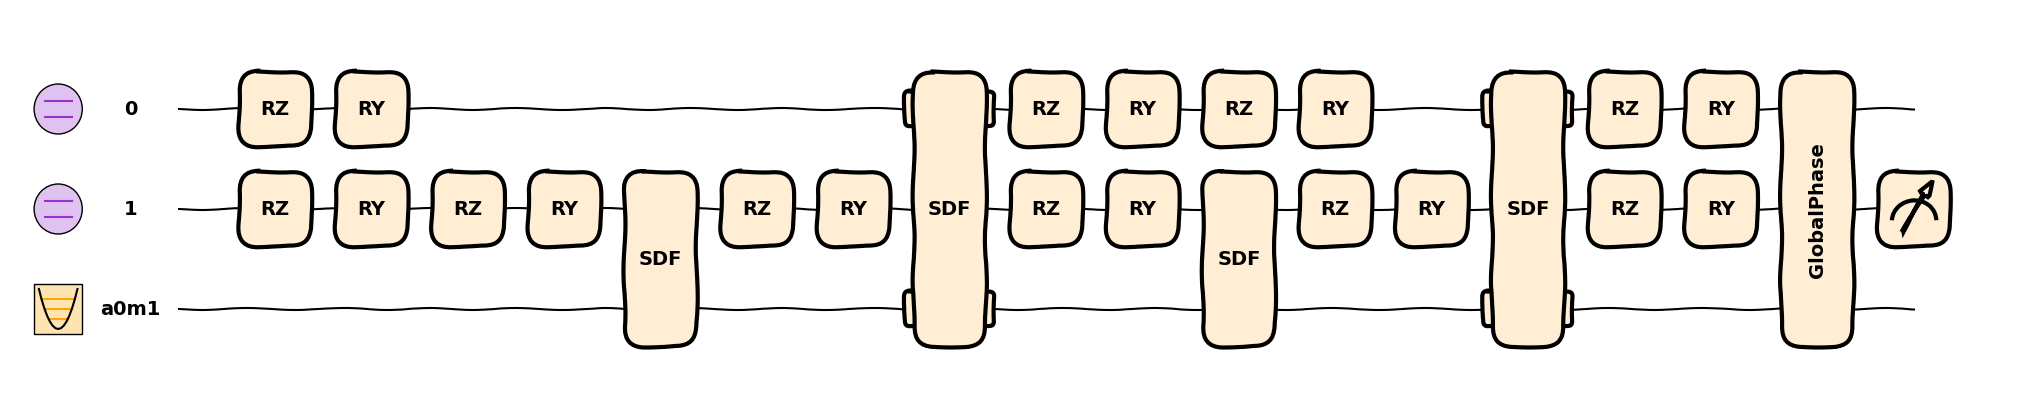

In [34]:
hqml.draw_mpl(qnode, level="device", style="sketch", **draw_options)(0.5)
plt.show()

Now let's export our circuit to Jaqal so it can be run on-device.

In [35]:
from hybridlane.devices.sandia_qscout import to_jaqal

ir = to_jaqal(qnode, level="device", precision=5)(0.5)
print(ir)

register q[2]

prepare_all
Rz q[1] 3.1416
Ry q[1] 1.5708
Rz q[1] 3.1416
Ry q[1] 1.5708
SDF q[1] 0.5 0.0
Rz q[1] 3.1416
Ry q[1] 1.5708
Rz q[0] 3.1416
Ry q[0] 1.5708
SDF q[0] 3.0616e-17 0.5
Rz q[0] 3.1416
Ry q[0] 1.5708
Rz q[1] 3.1416
Ry q[1] 1.5708
SDF q[1] -0.5 0.0
Rz q[1] 3.1416
Ry q[1] 1.5708
Rz q[0] 3.1416
Ry q[0] 1.5708
SDF q[0] -3.0616e-17 -0.5
Rz q[0] 3.1416
Ry q[0] 1.5708
Rz q[1] 3.1416
Ry q[1] 1.5708

measure_all


Thus we've shown the full pipeline from defining a circuit, validating it with Bosonic Qiskit, then transpiling it to the ion trap and exporting it to Jaqal.